# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Friday, October 24, 2025, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a multilayer perceptron (MLP).

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  

> Good luck, comrade!

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import math
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import re
from matplotlib.patches import Rectangle, FancyArrowPatch
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a multilayer perceptron (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering.
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Improve performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning hyperparameters.

> Note: There are no restrictions on the tricks you can use — Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How can you make sure the results are reproduable?
   
We made the results repoducable by using a set seed, making the model deterministic

    - Visualize the network's architecture and decision boundary.
Which optimizer did you choose? Discuss the differences between SGD and Adam.

We used Adam. Adam uses both momentum and RMSprop to adjust learning rate during training. SGD does not adjust the learning rate by itself, but makes gradients be calculated based on a small batch instead of the whole dataset

    - Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?

The learing rate scheduling improved performance. This is because at the beginning when the model is not fitted to the data, a higher learning rate is needed to make the model learn faster. As the model gets fitted to the data, the learning rate is decreased to make the model not get overfitted to the data and still learns the generality from the data.

The warmup phase also limited the instability that comes in the beginning of the training.

    - Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.
Baseline: 92.4%
With flat learningrate: 91.4%
With SGD instead of Adam: 83.8%
With neural net of 3 hidden layers (Linear(2,32), Relu(), Linear(32,2)): 89.6%
With 1000 epochs instead of 200: 88.4%

In [37]:
data = pd.read_csv('nn_data.csv')
train = data[data['split'] == 'train']
test = data[data['split'] == 'test']

train_X = torch.from_numpy(train.drop(columns=['y', 'split']).values)
test_X = torch.from_numpy(test.drop(columns=['y', 'split']).values)
train_X = train_X.float()
test_X = test_X.float()


train_y = torch.from_numpy(train['y'].values).long()
test_y = torch.from_numpy(test['y'].values).long()

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

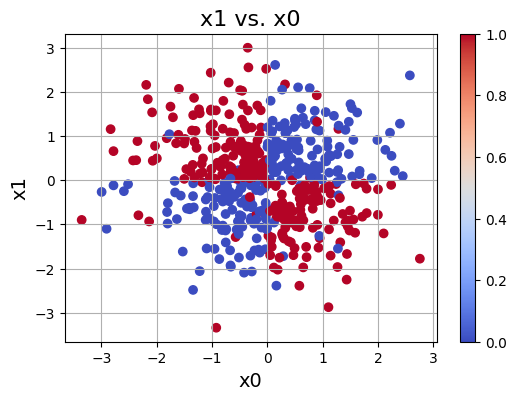

In [38]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()
plt.show()

In [39]:
class NeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (train_X, train_y) in enumerate(dataloader):
        pred = model(train_X)
        loss = loss_fn(pred, train_y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(train_X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for test_X, test_y in dataloader:
            pred = model(test_X)
            test_loss += loss_fn(pred, test_y).item()
            correct += (pred.argmax(1) == test_y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [40]:
# Build the nevral network with multiple layers 
# https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

model = NeuralNetwork().to("cpu")
print(model)

logits = model(train_X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)
Predicted class: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 

Epoch 1
-------------------------------
loss: 0.684942  [   50/  500]
Test Error: 
 Accuracy: 47.8%, Avg loss: 0.691943 

Epoch 2
-------------------------------
loss: 0.686539  [   50/  500]
Test Error: 
 Accuracy: 48.6%, Avg loss: 0.689264 

Epoch 3
-------------------------------
loss: 0.673557  [   50/  500]
Test Error: 
 Accuracy: 49.6%, Avg loss: 0.683765 

Epoch 4
-------------------------------
loss: 0.663899  [   50/  500]
Test Error: 
 Accuracy: 58.4%, Avg loss: 0.673656 

Epoch 5
-------------------------------
loss: 0.678949  [   50/  500]
Test Error: 
 Accuracy: 65.4%, Avg loss: 0.657416 

Epoch 6
-------------------------------
loss: 0.651902  [   50/  500]
Test Error: 
 Accuracy: 74.4%, Avg loss: 0.631830 

Epoch 7
-------------------------------
loss: 0.648731  [   50/  500]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.592968 

Epoch 8
-------------------------------
loss: 0.582936  [   50/  500]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.535478 

Epoch 9
----------------

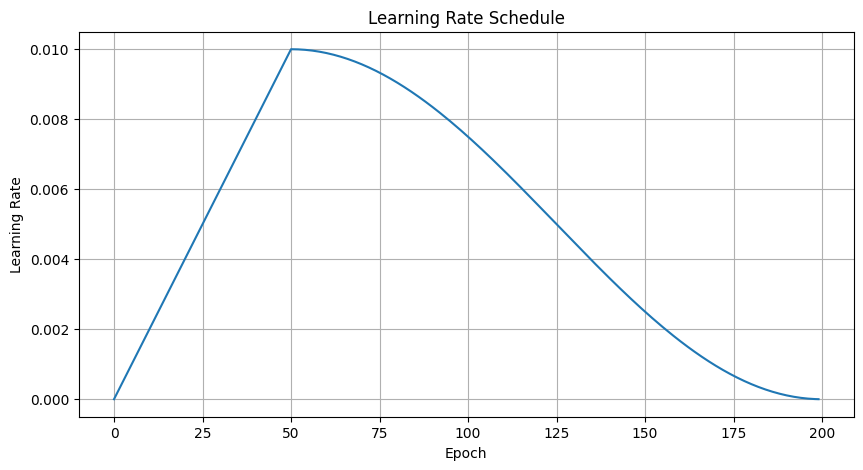

In [41]:
# Hypermeter specification
min_lr = 1e-7
max_lr = 1e-2
batch_size = 50
epochs = 200
warmup_epochs = 50

loss_fn = nn.CrossEntropyLoss()

generator = torch.Generator().manual_seed(42)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


optimizer = torch.optim.Adam(model.parameters(), lr=min_lr)

learning_rates = []

for t in range(epochs):
    if t < warmup_epochs:
        learning_rate = min_lr + (max_lr - min_lr) * (t / warmup_epochs)
    else:
        progress = (t - warmup_epochs) / (epochs - warmup_epochs)
        learning_rate = min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(math.pi * progress))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    learning_rates.append(learning_rate)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

plt.figure(figsize=(10, 5))
plt.plot(learning_rates)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

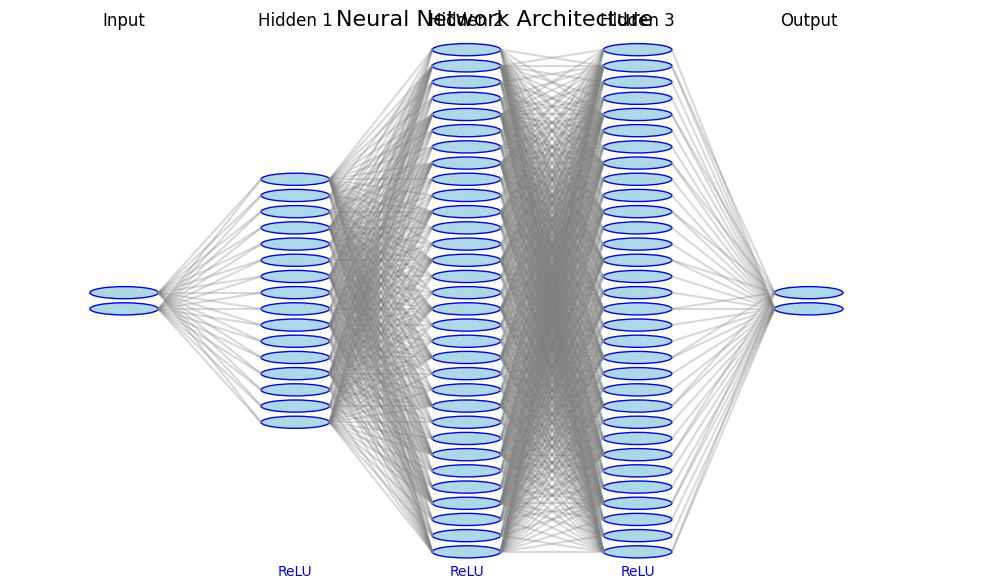

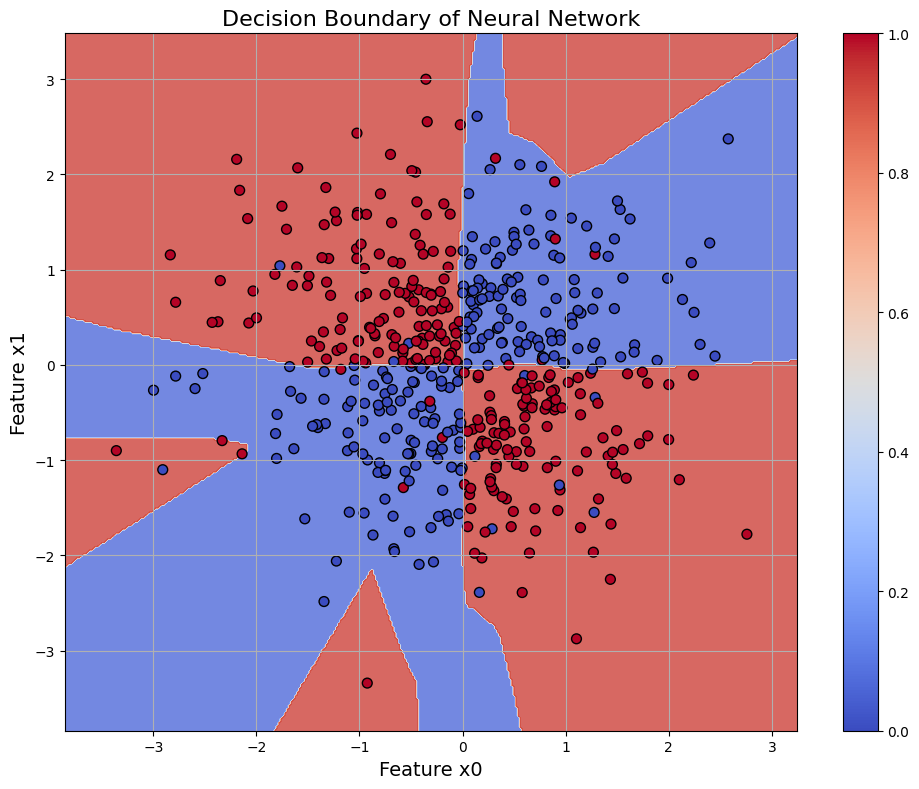

In [42]:
# Visualization of the network's architecture and decision boundary
# Generated with LLMs

def visualize_network_architecture(model):
    """Visualizes the architecture of a neural network using matplotlib"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define the architecture parameters
    layers = [2, 16, 32, 32, 2]  # Nodes in each layer
    layer_names = ['Input', 'Hidden 1', 'Hidden 2', 'Hidden 3', 'Output']
    activations = ['', 'ReLU', 'ReLU', 'ReLU', '']
    
    # Define spacing
    layer_spacing = 1.5
    node_spacing = 0.8
    node_size = 0.3
    
    # Setup plot area
    ax.axis('off')
    ax.set_xlim(-1, layer_spacing * len(layers))
    max_nodes = max(layers)
    ax.set_ylim(-1, node_spacing * max_nodes)
    
    # Plot nodes and connections
    for i, (layer_size, name) in enumerate(zip(layers, layer_names)):
        # Calculate vertical offset to center the layer
        offset = (max_nodes - layer_size) * node_spacing / 2
        
        # Draw layer title
        ax.text(i * layer_spacing, max_nodes * node_spacing + 0.2, name, 
                ha='center', va='bottom', fontsize=12)
        
        # Draw activation function name
        if activations[i]:
            ax.text(i * layer_spacing, -0.6, activations[i], 
                    ha='center', va='top', fontsize=10, color='blue')
        
        # Draw nodes
        for j in range(layer_size):
            circle = plt.Circle((i * layer_spacing, j * node_spacing + offset), 
                               node_size, fill=True, color='lightblue', ec='blue')
            ax.add_patch(circle)
            
            # Draw connections to next layer
            if i < len(layers) - 1:
                next_offset = (max_nodes - layers[i+1]) * node_spacing / 2
                for k in range(layers[i+1]):
                    # Only draw some connections to avoid clutter
                    if layer_size > 10 and j % 3 != 0 and k % 3 != 0:
                        continue
                        
                    ax.plot([i * layer_spacing + node_size, (i+1) * layer_spacing - node_size],
                            [j * node_spacing + offset, k * node_spacing + next_offset],
                            'gray', alpha=0.3)
    
    plt.title('Neural Network Architecture', fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function
visualize_network_architecture(model)

def plot_decision_boundary(model, X, y):
    """Plot the decision boundary created by the trained neural network model"""
    
    # Set min and max values with some padding
    x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x1_min, x1_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a grid of points
    h = 0.02  # Step size
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h), 
                         np.arange(x1_min, x1_max, h))
    
    # Flatten the grid and convert to PyTorch tensor
    grid = np.c_[xx0.ravel(), xx1.ravel()]
    grid_tensor = torch.FloatTensor(grid)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(grid_tensor)
        _, predicted = torch.max(outputs, 1)
        
    # Reshape the predictions back to the grid shape
    predicted = predicted.numpy().reshape(xx0.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx0, xx1, predicted, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot the original data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k', s=50)
    
    plt.xlabel('Feature x0', fontsize=14)
    plt.ylabel('Feature x1', fontsize=14)
    plt.title('Decision Boundary of Neural Network', fontsize=16)
    plt.grid(True)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Convert data to numpy for plotting
X_train = train_X.numpy()
y_train = train_y.numpy()

# Call the function to plot the decision boundary
plot_decision_boundary(model, X_train, y_train)

# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts.

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.

We used UMAP to determine the correct number of cluster. This worked better than PCA since it can't capture the non-linear patterns which t-sne and umap can.

PCA is a linear dimensionality reduction method that changes the original features into new features that don't overlap with each other and the fist few keep the most important differences in the original data. 

t-sne is a non linear dimensionality reduction method that preserves local structure and patterns of the data. It works by looking at the similarity between data points and calculates the likelihood that they are near each other

Umap is similar to t-sne but offers several advantages, including better preservation of global data structure and faster computation times.

   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.

We used K-means with hyperparameters n_clusters = 4 (trial and error) and n_init = 40. K-means clusters points together based on their inherent similarities. DBSCAN groups data points closely packed together and marks outliers as noise. DBSCAN performs well on clusters that are any shape not just circular or convex compared to k-means.

   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?

The hidden data type of the dataset is geographical 128x128 images, with hotspots/peaks where the server is located. The pictures are rotated differently. This information influences feature extraction for clustering in several ways. UMAP and t-SNE are able to seperate rotated groups, while PCA captures the rotation as variance. When we use UMAP with 10 dimensions it keeps images with hotspots in the same place close together, so KMeans can separate groups cleanly.

   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.

Server Locations: 
* Trondheim Spektrum
* Studenter Samfundet
* Ikea Leangen
* Pirbadet

We sorted the columns and then visualized the data as 128x128 pixel images. To find the locations we used local knowledge and compared the pictures to google maps.


   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.

In [43]:
# Hmmmmm, why is the first row skipped?
data = pd.read_csv('unsupervised_data.csv', skiprows=1, header=None)
# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index': 'ID'}, inplace=True)

In [44]:
X = data.select_dtypes(include=[np.number]).values
Xs = RobustScaler().fit_transform(X)

# PCA to 95% variance
pca = PCA(n_components=None, svd_solver="full", random_state=42)
Z = pca.fit_transform(Xs)
cum = np.cumsum(pca.explained_variance_ratio_)
k_pcs = int(np.searchsorted(cum, 0.95) + 1)
Z = Z[:, :max(2, k_pcs)]

import umap
Zu = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=10, random_state=42).fit_transform(Xs)
best = (-1, None, None)
for k in range(2, 21):
    labs = KMeans(n_clusters=k, n_init=40, random_state=42).fit_predict(Zu)
    sil = silhouette_score(Zu, labs)
    if sil > best[0]:
        best = (sil, k, labs)
labs = best[2]
print("UMAP10D+KMeans silhouette:", best[0])

sub = pd.DataFrame({"ID": data["ID"].values, "cluster": labs.astype(int)})
sub.to_csv("submission.csv", index=False)

C:\Users\Vetle\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP10D+KMeans silhouette: 0.764055073261261


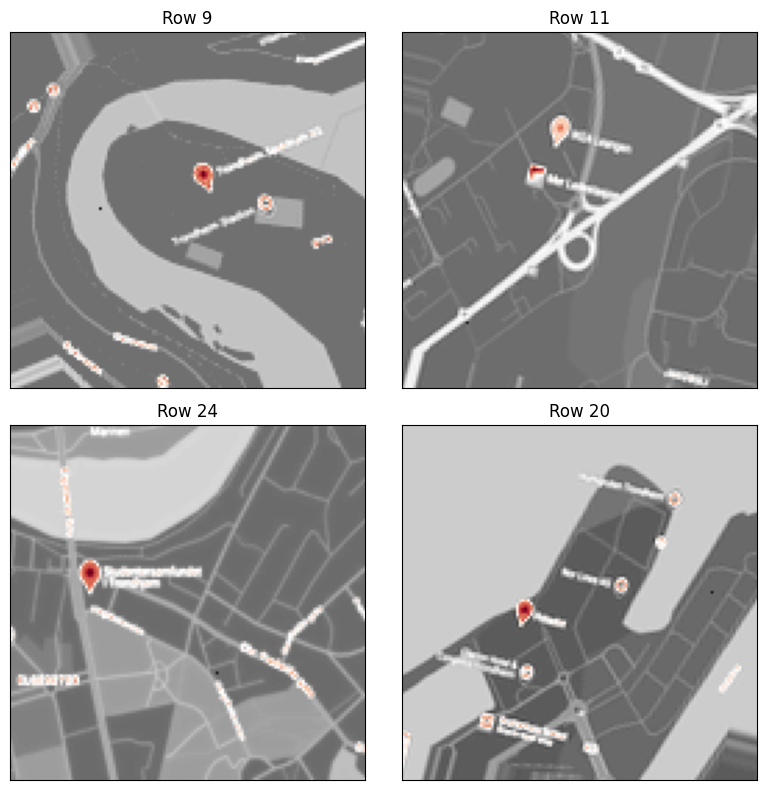

In [45]:
df = pd.read_csv("unsupervised_data.csv")
feat_cols = [c for c in df.columns if c.startswith("col_")]
X = df[feat_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).values
idx = np.array([int(re.fullmatch(r"col_(\d+)", c).group(1)) for c in feat_cols])

rows = idx // 128
cols = idx % 128

def reconstruct(vals):
    img = np.zeros((128, 128), float)
    img[rows, cols] = vals
    img = img[::-1, :]
    return img

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()
for ax, i in zip(axes, [9, 11, 24, 20]):
    img = reconstruct(X[i])
    im = ax.imshow(img, origin="lower", cmap="RdGy")
    ax.set_title(f"Row {i}")
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

In [46]:
# The dataset is heavy. Applying clustering directly on the dataset is likely not feasible. 
# data.info(0)

In [47]:
# Features seem to be similarly distributed...
# plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
# plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
# plt.legend()
# plt.show()

In [48]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
# sample_submission = pd.read_csv('sample_submission.csv')
# sample_submission


---

## 🎯 Note: Clustering Accuracy Evaluation

The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation is solely based on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [49]:
import numpy as np
import scipy.optimize
import sklearn.metrics

def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy

In [50]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(1.0)

In [51]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.3333333333333333)

In [52]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.5)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cd10384d-28df-431e-b0f2-62886eff090a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>